### running the evaluation for the challenge dataset

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
from torchinfo import summary
from collections import defaultdict, namedtuple
import pandas as pd
import proplot as pplt
import warnings
warnings.filterwarnings("ignore") # I should only put this in place when I am doing plotting and using proplot....
from twaibrain.braintorch.utils.resize import crop_or_pad_dims
from twaibrain.brainpreprep.utils.image_io import load_image
import scipy
import scipy.stats

# model architecture
import json
from twaibrain.braintorch.models.nnUNet.nnUNetV2_model_loader import get_network_from_plans
from twaibrain.braintorch.models.ssn import SSN_Wrapped_Deep_Supervision, SSN_Wrapped_Deep_Supervision_LLO, Hierarchical_SSN_with_ConvRefine, Hierarchical_SSN_with_ConvSpatialAttention

# fitting code
from twaibrain.braintorch.fitting_and_inference.get_trainer import get_trainer
from twaibrain.braintorch.fitting_and_inference.get_scratch_dir import scratch_dir
from twaibrain.braintorch.fitting_and_inference.optimizer_constructor import OptimizerConfigurator
from twaibrain.braintorch.fitting_and_inference.lightning_fitter import StandardLitModelWrapper

# loss function
from twaibrain.braintorch.losses.ssn_losses import DeepSupervisionSSN, SSNCombinedDiceXent_and_MC_loss, SSNCombinedDiceXent_and_MC_loss_FromSamples
from twaibrain.braintorch.losses.generic_deep_supervision import MultiDeepSupervisionLoss, DeepSupervisionLoss
from twaibrain.braintorch.losses.dice_loss import SoftDiceV2
from twaibrain.braintorch.losses.xent import dice_xent_loss

# data
from twaibrain.brainexperiments.run_nnUNet_v2.old_dataloading.dataset_pipelines import load_data
from twaibrain.braintorch.data.legacy_dataset_types.dataset_wrappers import MonaiAugmentedDataset
from twaibrain.braintorch.augmentation.nnunet_augmentations import get_nnunet_transforms, get_val_transforms
from torch.utils.data import ConcatDataset
from twaibrain.braintorch.data.legacy_dataset_types.mri_dataset_inram import MRISegmentation3DDataset
from twaibrain.braintorch.data.legacy_dataset_types.mri_dataset_from_file import MRISegmentationDatasetFromFile, ArrayMRISegmentationDatasetFromFile
from twaibrain.braintorch.data.legacy_dataset_types.mri_dataset_directory_parsers import *

# evaluation code
from twaibrain.brainexperiments.run_nnUNet_v2.evaluation.eval_helper_functions import *
from twaibrain.brainexperiments.run_nnUNet_v2.evaluation.model_predictions import get_means_and_samples_2D
from twaibrain.brainexperiments.run_nnUNet_v2.evaluation.model_predictions import *

### setting up params for the rest of the code to run

In [4]:
ARGS = namedtuple("args", "dataset test_split val_split seed " + 
                  "empty_slice_retention batch_size cross_validate cv_split cv_test_fold_smooth no_test_fold " +
                  "num_workers dice_factor xent_factor xent_reweighting eval_split uncertainty_type"
)

In [5]:
VOXELS_TO_WMH_RATIO = 382
VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES = 140
ESR = 0.5


# setup xent reweighting factor
XENT_VOXEL_RESCALE = VOXELS_TO_WMH_RATIO - (1-ESR) * (VOXELS_TO_WMH_RATIO - VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES)

XENT_WEIGHTING = XENT_VOXEL_RESCALE/2

In [21]:
args = ARGS(
    dataset = "chal",
    
    test_split=0.15,
    val_split=0.15,
    eval_split='all',

    seed=5,

    empty_slice_retention=ESR,

    uncertainty_type="ssn",

    batch_size=2,
    cross_validate=True,
    cv_split=0,
    cv_test_fold_smooth=1,
    no_test_fold="false",
    num_workers=16,

    dice_factor=1,
    xent_factor=1,
    xent_reweighting=XENT_WEIGHTING
)

### loading eval data

In [7]:
data_dict = load_data(
    dataset=args.dataset, 
    test_proportion=args.test_split, 
    validation_proportion=args.val_split,
    seed=args.seed,
    empty_proportion_retained=args.empty_slice_retention,
    batch_size=args.batch_size,
    dataloader2d_only=False,
    cross_validate=args.cross_validate,
    cv_split=args.cv_split,
    cv_test_fold_smooth=args.cv_test_fold_smooth,
    merge_val_test=args.no_test_fold
)

39 9 12


In [8]:
if args.eval_split == "all":
    eval_ds = ConcatDataset([data_dict['train_dataset3d'], data_dict['val_dataset3d'], data_dict['test_dataset3d']])
else:
    eval_ds = data_dict[f'{args.eval_split}_dataset3d']

In [9]:
len(eval_ds)

60

In [11]:
# get the xs and ys
xs3d_test = []
ys3d_test = []

for i, data in enumerate(eval_ds):
    ys3d_test.append(data[1].squeeze())
    xs3d_test.append(data[0])

In [12]:
ys3d_test = [y * (y==1).type(y.dtype) for y in ys3d_test] # fix bug with challenge data having 3 classes on cluster only?
gt_vols = GT_volumes(ys3d_test)

In [13]:
# to run on the nnUnet version of the model,
# I should crop the x and y to the min and max points
# this will also effectively centre the images for evaluation.
for i in range(len(xs3d_test)):
    x = xs3d_test[i]
    y = ys3d_test[i]
    wheres = torch.where(x[-1])
    zs = (wheres[0].min().item(), wheres[0].max().item())
    xs = (wheres[1].min().item(), wheres[1].max().item())
    ys = (wheres[2].min().item(), wheres[2].max().item())
    # print(zs, xs, ys)
    # print(x.shape, y.shape)

    x = x[:, zs[0]:zs[1]+1, xs[0]:xs[1]+1, ys[0]:ys[1]+1]
    y = y[zs[0]:zs[1]+1, xs[0]:xs[1]+1, ys[0]:ys[1]+1]

    # print(x.shape, y.shape)
    
    x = crop_or_pad_dims(x, [1,2,3], [48, 192, 192])
    y = crop_or_pad_dims(y, [0,1,2], [48, 192, 192])

    x = x.unsqueeze(0)

    # print(x.shape, y.shape)
    # print()
    xs3d_test[i] = x
    ys3d_test[i] = y

(-0.5, 191.5, -0.5, 191.5)

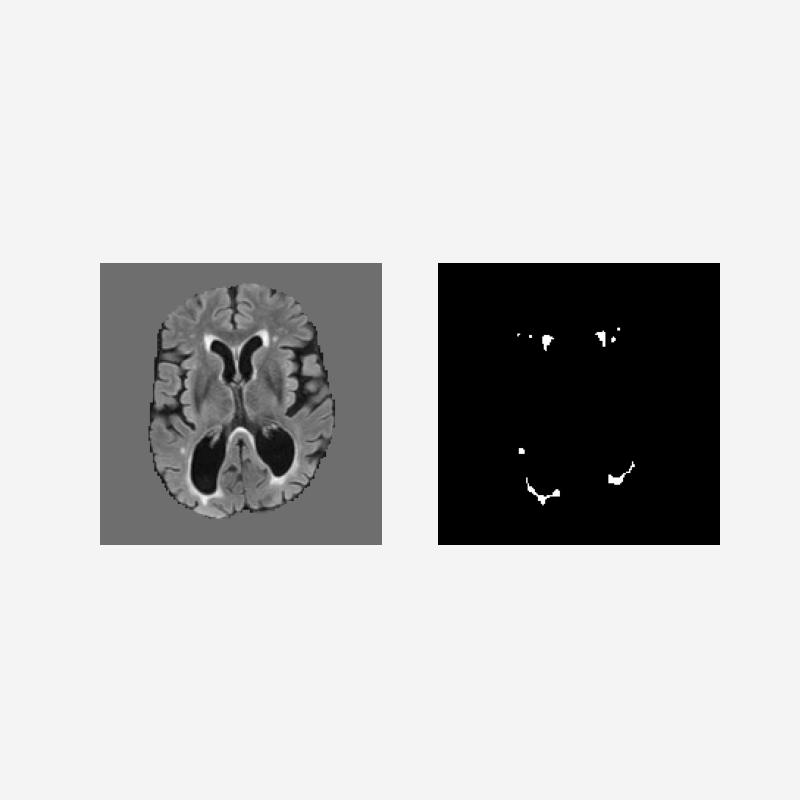

In [14]:
plt.subplot(1,2,1)
plt.imshow(xs3d_test[30][0][0][24], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ys3d_test[30][24], cmap='gray', origin='lower')
plt.axis('off')

### load a model checkpoint and get relevant predictions

In [15]:
model_config = "/home/s2208943/projects/twaibrain/twaibrain/braintorch/models/nnUNet/cvd_configs/nnUNetResEncUNetMPlans.json"

with open(model_config) as f:
    model_config = json.load(f)

In [18]:
dims = "2d"
config = model_config['configurations'][dims]['architecture']
network_name = config['network_class_name']
kw_requires_import = config['_kw_requires_import']

model = get_network_from_plans(
    arch_class_name=network_name,
    arch_kwargs=config['arch_kwargs'],
    arch_kwargs_req_import=kw_requires_import,
    input_channels=3,
    output_channels=32,
    allow_init=True,
    deep_supervision=True,
)

In [19]:
ssn_config = {
    'intermediate_channels':32,
    'out_channels':2,
    'dims':2,
    'rank':25,
    'diagonal':False,
}

ssn_model = SSN_Wrapped_Deep_Supervision(model, 5, ssn_config)

ssnllo_model = SSN_Wrapped_Deep_Supervision_LLO(model, ssn_config)

In [20]:
%autoreload

In [80]:
def get_model_preds(cv_fold, model=model, model_name="nnunet", ckpt_path=None, model_func=deterministic_mean, do_reorder_samples=False):
    litmodel = load_best_checkpoint(model, None, '.', cv_fold, ckpt_path)

    means, samples, miscs = get_means_and_samples_2D(litmodel.model, zip(xs3d_test, ys3d_test), 10, model_func)

    print(means[0].shape, samples[0].shape, ys3d_test[0].shape)

    means = [m.squeeze(0).swapaxes(0, 1) for m in means]
    means = [m[:,:2] for m in means]
    if samples[0] is not None:
        samples = [s.swapaxes(2, 3) for s in samples]
        samples = [s[:,:,:,:2].squeeze() for s in samples]
        

    print(means[0].shape, samples[0].shape)

    chal_results = per_model_chal_stats(means, ys3d_test)

    rmses = []
    for m, y in zip(means, ys3d_test):
        m = m.cuda()
        m = m.softmax(dim=1)[:,:2]
        rmses.append(fast_rmse(m, y.cuda()).cpu())
    rmses = torch.Tensor(rmses)
    chal_results['rmse'] = rmses

    chal_results['gt_vols'] = gt_vols

    # run the evaluation on the samples
    print("GETTING PER SAMPLE RESULTS")
    if samples[0] is not None:
        if do_reorder_samples:
            samples = [reorder_samples(s) for s in samples]
        sample_top_dices, sample_dices = per_sample_metric(samples, ys3d_test, f=fast_dice, do_argmax=True, do_softmax=False, minimise=False)
        sample_best_avds, sample_avds = per_sample_metric(samples, ys3d_test, f=fast_avd, do_argmax=True, do_softmax=False, minimise=True)
        sample_best_rmses, sample_rmses = per_sample_metric(samples, ys3d_test, f=fast_rmse, do_argmax=False, do_softmax=True, minimise=True)
    
        # best dice, avd, rmse
        chal_results['best_dice'] = sample_top_dices
        chal_results['best_avd'] = sample_best_avds
        chal_results['best_rmse'] = sample_best_rmses
        
        _, sample_vds = per_sample_metric(samples, ys3d_test, f=fast_vd, do_argmax=True, do_softmax=False, minimise=True, take_abs=False)
        sample_vd_skew = torch.from_numpy(scipy.stats.skew(sample_vds, axis=1, bias=True))
    
        # vd of the sample distribution
        chal_results['sample_vd_skew'] = sample_vd_skew
        for s in range(sample_vds.shape[1]):
            chal_results[f'sample_{s}_vd'] = sample_vds[:,s]
            
        # ged score
        geds = iou_GED(means, ys3d_test, samples)
        chal_results['GED^2'] = geds

    # get the uncertainty maps
    print("GENREATING UNCERTAINTY MAPS")
    uncertainty_thresholds = torch.arange(0, 0.7, 0.01)
    ent_maps = get_uncertainty_maps(means, samples, miscs, args)

    # pavpu
    print("PAVPU")
    all_acc_cert, all_uncert_inacc,all_pavpu = all_individuals_pavpu(means, ent_maps, ys3d_test, 4, 0.8, uncertainty_thresholds)
    
    for i, tau in enumerate(uncertainty_thresholds):
        chal_results[f'p_acc_cert_{tau:.2f}'] = all_acc_cert[:,i]
        chal_results[f'p_uncert_inacc_{tau:.2f}'] = all_uncert_inacc[:,i]
        chal_results[f'pavpu_{tau:.2f}'] = all_pavpu[:,i]
    
    # sUEO score and UEO per threshold
    print("UEO")
    sUEOs = get_sUEOs(means, ys3d_test, ent_maps)
    chal_results['sUEO'] = sUEOs
    ueos = UEO_per_threshold_analysis(uncertainty_thresholds, ys3d_test, ent_maps, means, 0.7)
    for i, tau in enumerate(uncertainty_thresholds):
        chal_results[f'UEO_{tau:.2f}'] = ueos[i]
    
    # 3D connected component analysis
    print("3D CC ANALYSIS")
    num_lesions_all, sizes_all, mean_missed_area3d_all, mean_size_missed_lesions3d_all, mean_cov_mean_missed_lesions3d_all, prop_lesions_missed3d_all = do_3d_cc_analysis_per_individual(means, ys3d_test, ent_maps, uncertainty_thresholds)
    for i, tau in enumerate(uncertainty_thresholds):
        chal_results[f'mean_missed_area3d_all_{tau:.2f}'] = torch.stack(mean_missed_area3d_all)[:,i]
        chal_results[f'mean_cov_mean_missed_lesions3d_all_{tau:.2f}'] = torch.stack(mean_cov_mean_missed_lesions3d_all)[:,i]
        chal_results[f'mean_size_missed_lesions3d_all_{tau:.2f}'] = torch.stack(mean_size_missed_lesions3d_all)[:,i]
        chal_results[f'prop_lesions_missed3d_all_{tau:.2f}'] = torch.stack(prop_lesions_missed3d_all)[:,i]
        

    # save the results
    print("SAVING RESULTS")
    results_out_dir = "/home/s2208943/ipdis/WMH_UQ_assessment/trustworthai/journal_run/evaluation/results/cross_validated_results/out_domain_results/"
    write_per_model_channel_stats(results_out_dir, model_name, f"{model_name}0_cv{cv_fold}", preds=None, ys3d_test=None, args=args, chal_results=chal_results)
    
    print("DONE")

In [81]:
%autoreload

### SSN V0

In [82]:
ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv0/epoch=66-step=18827.ckpt"
get_model_preds(0, model=ssn_model, model_name="ssnNnunetV0-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv1/epoch=56-step=16017.ckpt"
get_model_preds(1, model=ssn_model, model_name="ssnNnunetV0-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv2/epoch=41-step=11802.ckpt"
get_model_preds(2, model=ssn_model, model_name="ssnNnunetV0-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv3/epoch=41-step=11802.ckpt"
get_model_preds(3, model=ssn_model, model_name="ssnNnunetV0-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv4/epoch=34-step=9835.ckpt"
get_model_preds(4, model=ssn_model, model_name="ssnNnunetV0-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv5/epoch=75-step=21356.ckpt"
get_model_preds(5, model=ssn_model, model_name="ssnNnunetV0-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

60it [00:23,  2.57it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.68it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.07it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.01it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.30it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:58<00:00,  1.97s/it]


SAVING RESULTS
DONE


60it [00:21,  2.74it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.88it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.03it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.49it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.34it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:56<00:00,  1.95s/it]


SAVING RESULTS
DONE


60it [00:21,  2.74it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:11<00:00,  1.18s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.74it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.40it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.04it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.29it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:55<00:00,  1.92s/it]


SAVING RESULTS
DONE


60it [00:21,  2.77it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.79it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.22it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.77it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.38it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:57<00:00,  1.95s/it]


SAVING RESULTS
DONE


60it [00:21,  2.74it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.63it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.77it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.17it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.37it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:53<00:00,  1.89s/it]


SAVING RESULTS
DONE


60it [00:21,  2.75it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.96it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.66it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.85it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.37it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:53<00:00,  1.89s/it]


SAVING RESULTS
DONE


### SSN V1

In [83]:
ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv0/epoch=56-step=16017.ckpt"
get_model_preds(0, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv1/epoch=33-step=9554.ckpt"
get_model_preds(1, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv2/epoch=50-step=14331.ckpt"
get_model_preds(2, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv3/epoch=59-step=16860.ckpt"
get_model_preds(3, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv4/epoch=72-step=20513.ckpt"
get_model_preds(4, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv5/epoch=62-step=17703.ckpt"
get_model_preds(5, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

60it [00:21,  2.75it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:09<00:00,  1.15s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.83it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.32it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.13it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:14<00:00,  4.26it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:54<00:00,  1.91s/it]


SAVING RESULTS
DONE


60it [00:21,  2.76it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.13s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.66it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.85it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.50it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.31it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:59<00:00,  2.00s/it]


SAVING RESULTS
DONE


60it [00:21,  2.80it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:06<00:00,  1.11s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.00it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.12it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.27it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.43it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:52<00:00,  1.88s/it]


SAVING RESULTS
DONE


60it [00:21,  2.74it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:10<00:00,  1.17s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.94it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.66it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.31it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.36it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:50<00:00,  1.83s/it]


SAVING RESULTS
DONE


60it [00:21,  2.77it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.15s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.79it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.79it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.65it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:14<00:00,  4.23it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:56<00:00,  1.94s/it]


SAVING RESULTS
DONE


60it [00:21,  2.76it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.91it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.79it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.55it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.36it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:53<00:00,  1.90s/it]


SAVING RESULTS
DONE


### SSN V4

In [84]:
ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv0/epoch=56-step=16017.ckpt"
get_model_preds(0, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv1/epoch=54-step=15455.ckpt"
get_model_preds(1, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv2/epoch=50-step=14331.ckpt"
get_model_preds(2, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv3/epoch=60-step=17141.ckpt"
get_model_preds(3, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv4/epoch=56-step=16017.ckpt"
get_model_preds(4, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv5/epoch=41-step=11802.ckpt"
get_model_preds(5, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

60it [00:21,  2.79it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.91it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.37it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.65it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.38it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:53<00:00,  1.89s/it]


SAVING RESULTS
DONE


60it [00:21,  2.76it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.13s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.88it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.24it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.96it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.32it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:54<00:00,  1.92s/it]


SAVING RESULTS
DONE


60it [00:21,  2.74it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.06it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.38it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.96it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.37it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:53<00:00,  1.89s/it]


SAVING RESULTS
DONE


60it [00:21,  2.76it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.89it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.82it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.32it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.38it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:52<00:00,  1.87s/it]


SAVING RESULTS
DONE


60it [00:21,  2.74it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.15s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.87it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.20it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.61it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.29it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:50<00:00,  1.84s/it]


SAVING RESULTS
DONE


60it [00:21,  2.76it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.15s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.94it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.75it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.54it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.31it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:55<00:00,  1.92s/it]


SAVING RESULTS
DONE


### SSN V5

In [85]:
ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv0/epoch=23-step=6744.ckpt"
get_model_preds(0, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv1/epoch=586-step=164947.ckpt"
get_model_preds(1, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv2/epoch=7-step=2248.ckpt"
get_model_preds(2, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv3/epoch=13-step=3934.ckpt"
get_model_preds(3, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv4/epoch=1-step=562.ckpt"
get_model_preds(4, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv5/epoch=0-step=281.ckpt"
get_model_preds(5, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

60it [00:21,  2.75it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:51<00:00,  1.86s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.88it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.48it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.05it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.32it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [02:14<00:00,  2.23s/it]


SAVING RESULTS
DONE


60it [00:21,  2.74it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:01<00:00,  1.03s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.59it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.35it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.81it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.33it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:26<00:00,  1.44s/it]


SAVING RESULTS
DONE


60it [00:21,  2.75it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


 77%|████████████████████████████████████████████████▎              | 46/60 [05:54<01:47,  7.70s/it]

KeyboardInterrupt



### storing the model outputs

In [210]:
litmodel = get_model_preds(0)

In [307]:
def evaluate_dataset(model_raw, full_ds, mss3_ids, output_dir):
    start = 0
    end = 10
    
    while end < len(full_ds):
        ds = LimitedSizeDataset(full_ds, start=start, end=end)
        IDs = mss3_ids[start:end]
    
        start = end
        end += 10
    
        # get predictions
        means, samples, misc = get_nnunet_means_and_samples(model_raw, ds, num_samples=10, model_func_name=args.uncertainty_type, args=args)
        means = [m.squeeze(0).swapaxes(0, 1)[:,:2] for m in means]
        
        # get uncertainty maps
        ent_maps = get_uncertainty_maps(means, samples, misc, args)
    
        # write results
        write__output_map_results_to_disk(args, IDs, ent_maps, means, output_dir=output_dir)

        # break


In [209]:
mss3_parser = MSS3MultiRaterDataParser(
    # paths on the cluster for the in house data
    "/home/s2208943/datasets/Inter_observer",
    "/home/s2208943/preprocessed_data/MSS3_InterRaterData"
)

mss3_ds = ArrayMRISegmentationDatasetFromFile(mss3_parser) 

mss3_ids = [out[2] for out in mss3_ds]

mss3_output_dir = "/home/s2208943/preprocessed_data/MSS3_InterRaterData/output_maps/nnunet/"

In [322]:
len(mss3_ids)

68

In [311]:
domains_chal_train = ["training_Singapore", "training_Utrecht", "training_Amsterdam_GE3T"]
    
chal_ds_train = ConcatDataset([
    MRISegmentation3DDataset("/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/collated", no_labels=True, xy_only=False, domain_name=dn)
    for dn in domains_chal_train
])

chal_train_ids = [out[2] for out in chal_ds_train]

chal_train_output_dir = "/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/output_maps/training/nnunet/"

In [317]:
domains_chal_test = ["test_Amsterdam_GE1T5", "test_Amsterdam_Philips_VU_PETMR_01", "test_Utrecht", "test_Amsterdam_GE3T", "test_Singapore"]
    
chal_ds_test = ConcatDataset([
    MRISegmentation3DDataset("/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/collated", no_labels=True, xy_only=False, domain_name=dn)
    for dn in domains_chal_test
])

chal_test_ids = [out[2] for out in chal_ds_test]

chal_test_output_dir = "/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/output_maps/test/nnunet/"

In [319]:
ADNI_ds = MRISegmentation3DDataset("/home/s2208943/preprocessed_data/ADNI300/collated", no_labels=True, xy_only=False)
adni_ids = [out[2] for out in ADNI_ds]
adni_out_dir = "/home/s2208943/preprocessed_data/ADNI300/ADNI_300_output_maps/nnunet/"

In [320]:
evaluate_dataset(litmodel, ADNI_ds, adni_ids, adni_out_dir)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.13it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.02it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 53.89it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.22it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 203.38it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.19it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.62it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.22it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.26it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.19it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.38it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.26it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.20it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 211.67it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.12it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.93it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 124.69it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.07it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.61it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.15it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.69it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.18it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.01it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 84.79it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.84it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 189.47it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.96it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.18it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.25it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.24it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.48it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.20it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.64it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.95it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.60it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.30it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 191.21it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


In [318]:
evaluate_dataset(litmodel, chal_ds_test, chal_test_ids, chal_test_output_dir)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.13it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.12it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 199.49it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 194.62it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.01it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 179.48it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.74it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.11it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.26it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.32it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 205.15it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.25it/s]


In [315]:
%autoreload

In [316]:
evaluate_dataset(litmodel, chal_ds_train, chal_train_ids, chal_train_output_dir)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.60it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.13it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.41it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.25it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 166.19it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.17it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.14it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


In [245]:
len(mss3_ds)

68

In [308]:
evaluate_dataset(litmodel, mss3_ds, mss3_ids, mss3_output_dir)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.03s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 142.03it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.08s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 83.15it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.34it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


In [ ]:
### now train the fazekas model